# Tugas Text Klasifikasi
---

In [ ]:
# ==========================================
# 1. Import Library
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# ==========================================
# 2. Load Data
# ==========================================
df = pd.read_csv("https://drive.google.com/uc?id=1_BWt5EjvSw7wnN6mQDlHXv5L7-xj4Msl")
print(df.head())
print(df.info())

# Asumsi kolom teks = 'Text', target = 'Emotion'
text_col = "Text"
target_col = "Emotion"

                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB
None


In [ ]:
# ==========================================
# Stopwords Global
# ==========================================
custom_stopwords = {
    # Dari sebelumnya
    "feel", "feeling", "im", "i m", "ive",
    "like", "get", "really", "know", "would", "still", "time", "little",
    "even", "want", "one", "life", "people", "think", "bit", "things", "much", "dont",
    "could", "way", "going", "something", "pretty",
    "make", "day", "back", "right", "always", "go", "cant", "also", "need", "well",

    # Dari top words terbaru
    "today", "say", "made",        # sadness/happy
    "liked", "hot", "feelings",    # love
    "funny", "weird", "strange", "amazing",  # surprise/fear
    "see", "work", "enough", "sure",  # happy
    }

stop_words = stop_words.union(custom_stopwords)

# Stopwords khusus per emosi
class_specific_stopwords = {
    "sadness": {"love"}   # hanya hapus 'love' jika emosinya sadness
}

# ==========================================
# 3. Preprocessing Function
# ==========================================
def clean_text(text, emotion=None):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenisasi
    tokens = text.split()
    # Hapus stopwords global
    tokens = [word for word in tokens if word not in stop_words]
    # Hapus stopwords khusus kelas
    if emotion in class_specific_stopwords:
        tokens = [word for word in tokens if word not in class_specific_stopwords[emotion]]
    return " ".join(tokens)

# Terapkan dengan mempertimbangkan emosi
df["clean_text"] = df.apply(lambda row: clean_text(row[text_col], row[target_col]), axis=1)

/tmp/ipython-input-214339455.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


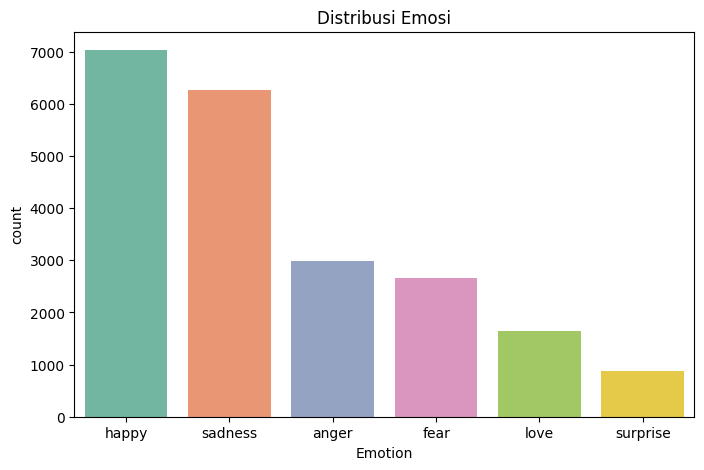

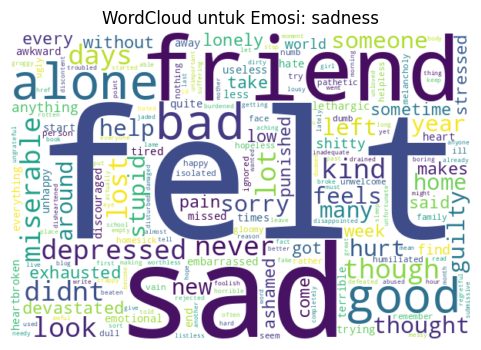

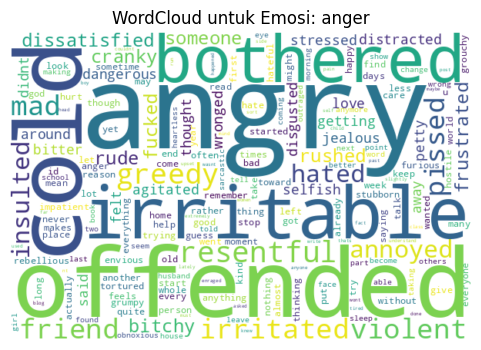

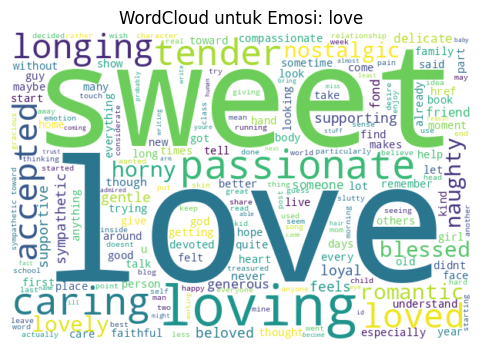

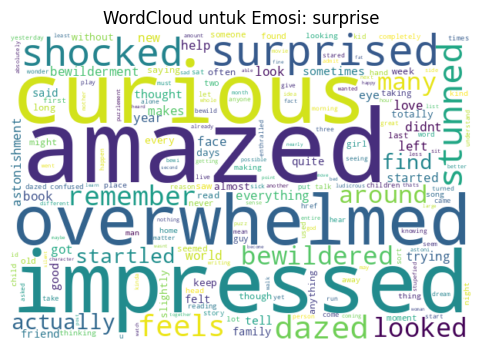

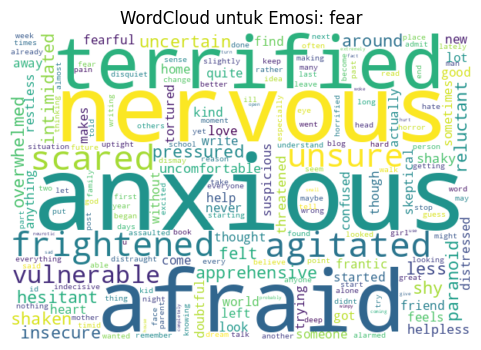

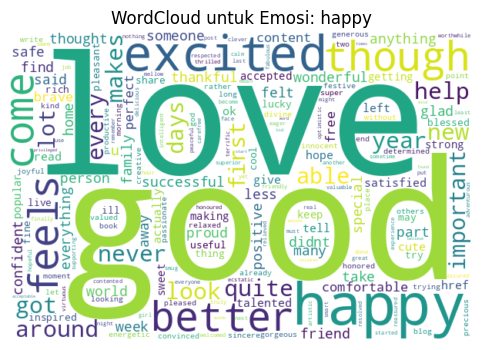

In [ ]:
# ==========================================
# 4. EDA (Exploratory Data Analysis)
# ==========================================
plt.figure(figsize=(8,5))
sns.countplot(
    x=target_col,
    data=df,
    order=df[target_col].value_counts().index,
    palette="Set2"
)
plt.title("Distribusi Emosi")
plt.show()

# WordCloud per kelas (gunakan teks hasil preprocessing)
for emo in df[target_col].unique():
    subset = df[df[target_col] == emo]
    text = " ".join(subset["clean_text"].astype(str))   # pakai clean_text
    wc = WordCloud(width=600, height=400, background_color="white").generate(text)
    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud untuk Emosi: {emo}")
    plt.show()

In [ ]:
# ==========================================
# 5. Top 10 Most Frequent Words per Emotion
# ==========================================
from collections import Counter

for emo in df[target_col].unique():
    subset = df[df[target_col] == emo]
    all_clean_text = " ".join(subset["clean_text"].astype(str))
    words = all_clean_text.split()
    word_counts = Counter(words)
    top_10_words = word_counts.most_common(10)

    print(f"\nTop 10 Most Frequent Words for Emotion: {emo}")
    for word, count in top_10_words:
        print(f"{word}: {count}")





Top 10 Most Frequent Words for Emotion: sadness
felt: 136
sad: 130
alone: 127
bad: 126
depressed: 123
good: 121
didnt: 112
never: 111
days: 110
miserable: 108

Top 10 Most Frequent Words for Emotion: anger
angry: 116
offended: 92
resentful: 87
cold: 86
irritable: 84
bothered: 81
greedy: 77
mad: 74
insulted: 73
irritated: 72

Top 10 Most Frequent Words for Emotion: love
love: 119
sweet: 84
loving: 82
caring: 78
passionate: 75
sympathetic: 72
tender: 64
lovely: 63
longing: 63
loved: 62

Top 10 Most Frequent Words for Emotion: surprise
amazed: 83
impressed: 72
curious: 72
overwhelmed: 69
surprised: 68
shocked: 54
stunned: 43
dazed: 43
feels: 30
remember: 26

Top 10 Most Frequent Words for Emotion: fear
anxious: 126
nervous: 103
terrified: 89
afraid: 85
agitated: 84
scared: 83
frightened: 82
unsure: 75
vulnerable: 75
apprehensive: 74

Top 10 Most Frequent Words for Emotion: happy
good: 246
love: 231
happy: 212
excited: 144
though: 138
quite: 135
feels: 133
better: 132
got: 127
around: 127

In [ ]:
# ==========================================
# 6. Train-Test Split + TF-IDF
# ==========================================
X = df["clean_text"]
y = df[target_col]

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# ==========================================
# 7. Model MultinomialNB
# ==========================================
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("=== MultinomialNB ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

=== MultinomialNB ===
Accuracy: 0.6875582479030755
              precision    recall  f1-score   support

       anger       0.93      0.38      0.54       599
        fear       0.93      0.29      0.44       530
       happy       0.63      0.97      0.77      1406
        love       1.00      0.08      0.15       328
     sadness       0.69      0.93      0.80      1253
    surprise       1.00      0.01      0.02       176

    accuracy                           0.69      4292
   macro avg       0.86      0.45      0.45      4292
weighted avg       0.77      0.69      0.63      4292



In [ ]:
# ==========================================
# 8. Model KNN + Hyperparameter Tuning
# ==========================================
param_grid = {
    "n_neighbors": [3,5,7,9],
    "metric": ["euclidean", "manhattan", "cosine"]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print("=== KNN Terbaik ===")
print("Best Params:", grid.best_params_)
print("Best Score (CV):", grid.best_score_)

y_pred_knn = grid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.32201343 0.31193599 0.309374   0.29411284        nan        nan
        nan        nan 0.74223788 0.77322766 0.78417916 0.78924686]
  warnings.warn(


=== KNN Terbaik ===
Best Params: {'metric': 'cosine', 'n_neighbors': 9}
Best Score (CV): 0.7892468602065993
Accuracy: 0.8084808946877913
              precision    recall  f1-score   support

       anger       0.80      0.77      0.78       599
        fear       0.80      0.74      0.77       530
       happy       0.79      0.91      0.85      1406
        love       0.86      0.51      0.64       328
     sadness       0.82      0.87      0.85      1253
    surprise       0.81      0.48      0.60       176

    accuracy                           0.81      4292
   macro avg       0.82      0.71      0.75      4292
weighted avg       0.81      0.81      0.80      4292



In [ ]:
# Dataset dummy tanpa label
dummy_texts = {
    "clean_text": [
        "felt so alone and depressed",     # sadness
        "im angry and really mad today",   # anger
        "love sweet caring person",        # love
        "amazed shocked and surprised",    # surprise
        "anxious nervous and terrified",   # fear
        "happy excited and better now",    # happy
        "irritable offended and mad",      # anger
        "passionate loving and caring",    # love
        "overwhelmed stunned and amazed",  # surprise
        "afraid vulnerable and unsure"     # fear
    ]
}

df_dummy_unlabeled = pd.DataFrame(dummy_texts)

print(df_dummy_unlabeled)

                       clean_text
0     felt so alone and depressed
1   im angry and really mad today
2        love sweet caring person
3    amazed shocked and surprised
4   anxious nervous and terrified
5    happy excited and better now
6      irritable offended and mad
7    passionate loving and caring
8  overwhelmed stunned and amazed
9    afraid vulnerable and unsure


In [ ]:
# Ubah ke TFIDF
X_dummy_unlabeled = tfidf.transform(df_dummy_unlabeled["clean_text"])

# Prediksi dengan MultinomialNB
pred_nb = nb.predict(X_dummy_unlabeled)

# Prediksi dengan KNN
pred_knn = grid.predict(X_dummy_unlabeled)

# Gabungkan hasil ke dataframe
df_dummy_unlabeled["Pred_NB"] = pred_nb
df_dummy_unlabeled["Pred_KNN"] = pred_knn

print(df_dummy_unlabeled)

                       clean_text   Pred_NB  Pred_KNN
0     felt so alone and depressed   sadness   sadness
1   im angry and really mad today     anger     anger
2        love sweet caring person     happy      love
3    amazed shocked and surprised  surprise  surprise
4   anxious nervous and terrified      fear      fear
5    happy excited and better now     happy     happy
6      irritable offended and mad     anger     anger
7    passionate loving and caring      love      love
8  overwhelmed stunned and amazed  surprise  surprise
9    afraid vulnerable and unsure      fear      fear


#**Kesimpulan**:
Hasil analisis menunjukkan bahwa kedua model (MultinomialNB dan KNN) mampu memprediksi emosi dengan konsisten, meskipun terdapat sedikit perbedaan pada kasus tertentu sehingga MultinomialNB cenderung lebih stabil.